In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Input File
Unzip the input file.

Using the frames of the input video 'test.mp4' using

`ffmpeg -i <your_video>.mp4 -q:v 2 -start_number 0 <output_dir>/'%05d.jpg'`

where -q:v generates high-quality JPEG frames and -start_number 0 asks ffmpeg to start the JPEG file from 00000.jpg.

In [4]:
!unzip /content/test.zip

Archive:  /content/test.zip
replace __MACOSX/._test? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Running the assignment on colab with A100 GPU.

In [5]:
using_colab = True

Installing the sam2 files and checkpoints from Github.

In [6]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

PyTorch version: 2.5.1+cu121
Torchvision version: 0.20.1+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-5swl_ngu
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-5swl_ngu
  Resolved https://github.com/facebookresearch/sam2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 9.3 MB/s eta 0:00:00
  Created wheel for SAM-2: filename=SAM_2-1.0-cp311-c

In [7]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
#os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [8]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


#TASK 1: Writing a code to return the coordinates of the left and right hand for tracking.
Using [mediapipe](https://mediapipe-studio.webapps.google.com/demo/hand_landmarker) for this task.

In [9]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 61.1 MB/s eta 0:00:00


In [10]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "/content/test"

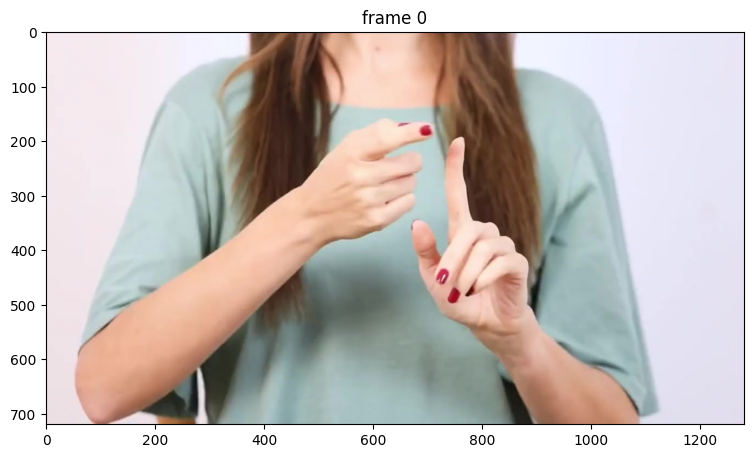

In [11]:
# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

In [12]:
import cv2
import mediapipe as mp

# Function to extract hand coordinates from a specific frame
def get_hand_coordinates(video_dir, frame_index):
    # Construct the frame path
    frame_path = os.path.join(video_dir, f"{frame_index:05d}.jpg")

    # Load the frame
    if not os.path.exists(frame_path):
        raise FileNotFoundError(f"Frame {frame_path} does not exist.")

    image = cv2.imread(frame_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Initialize MediaPipe Hands
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5)

    # Process the image
    results = hands.process(image_rgb)

    # Initialize coordinates
    left_hand_coord = None
    right_hand_coord = None

    # Extract hand landmarks if any
    if results.multi_hand_landmarks and results.multi_handedness:
        for hand_landmarks, handedness in zip(results.multi_hand_landmarks, results.multi_handedness):
            # Get the label (Left or Right)
            label = handedness.classification[0].label
            # Get the wrist landmark (landmark[0])
            wrist = hand_landmarks.landmark[0]
            x, y = int(wrist.x * image.shape[1]), int(wrist.y * image.shape[0])

            if label == "Left":
                left_hand_coord = np.array([x, y], dtype=np.float32)
            elif label == "Right":
                right_hand_coord = np.array([x, y], dtype=np.float32)

    hands.close()

    return left_hand_coord, right_hand_coord

In [13]:
# example

# Extract hand coordinates from the specified frame
left_hand, right_hand = get_hand_coordinates(video_dir, 0)

# Print the extracted hand coordinates
print("Left hand coordinate:", left_hand)
print("Right hand coordinate:", right_hand)

Left hand coordinate: [486. 335.]
Right hand coordinate: [805. 533.]


# Task 2: Masking the hand using the sam2 predictor.

Designed a function that uses [sam2](https://github.com/facebookresearch/sam2?tab=readme-ov-file) to track and segment both hands. The output is then combined to a video using opencv.

In [15]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [16]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 210/210 [00:06<00:00, 31.02it/s]


In [17]:
predictor.reset_state(inference_state)

In [18]:
from io import BytesIO

def process_video_with_segmentation(video_dir, get_hand_coordinates, predictor, inference_state, output_video_path="output.mp4", vis_frame_stride=30):
    """
    Processes a video directory with frame-based segmentation and outputs a video.

    Args:
        video_dir (str): Path to the directory containing video frames.
        get_hand_coordinates (function): Function to get hand coordinates from a frame.
        predictor (object): Predictor object for segmentation.
        inference_state (object): Inference state for the predictor.
        output_video_path (str): Path to save the output video.
        vis_frame_stride (int): Visualization stride for rendering frames.

    Returns:
        None
    """
    def show_mask(mask, ax, obj_id=None, random_color=False):
        if random_color:
            color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
        else:
            cmap = plt.get_cmap("tab10")
            cmap_idx = 0 if obj_id is None else obj_id
            color = np.array([*cmap(cmap_idx)[:3], 0.6])
        h, w = mask.shape[-2:]
        mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
        ax.imshow(mask_image)

    def show_points(coords, labels, ax, marker_size=200):
        pos_points = coords[labels == 1]
        neg_points = coords[labels == 0]
        ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
        ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

    # Initialize video writer
    frame_names = sorted(os.listdir(video_dir))
    sample_frame_path = os.path.join(video_dir, frame_names[0])
    height, width = cv2.imread(sample_frame_path).shape[:2]
    out_video = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*"mp4v"), 30, (width, height))

    # Process the initial frame
    ann_frame_idx = 0  # Frame index to process
    left_hand, right_hand = get_hand_coordinates(video_dir, ann_frame_idx)

    if left_hand is None and right_hand is None:
        raise ValueError("No hands detected in the frame.")

    points = np.array([coord for coord in [left_hand, right_hand] if coord is not None], dtype=np.float32)
    labels = np.array([1] * len(points), np.int32)

    ann_obj_id = 1  # Unique ID for the object
    _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
        inference_state=inference_state,
        frame_idx=ann_frame_idx,
        obj_id=ann_obj_id,
        points=points,
        labels=labels,
    )

    # Collect segmentation results
    video_segments = {}
    for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
        video_segments[out_frame_idx] = {
            out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
            for i, out_obj_id in enumerate(out_obj_ids)
        }

    # Render segmentation results and save to video
    for out_frame_idx in range(len(frame_names)):
        frame_path = os.path.join(video_dir, frame_names[out_frame_idx])
        frame = cv2.imread(frame_path)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        fig, ax = plt.subplots(figsize=(6, 4))
        ax.imshow(frame_rgb)
        ax.axis("off")
        plt.title(f"frame {out_frame_idx}")

        if out_frame_idx in video_segments:
            for out_obj_id, out_mask in video_segments[out_frame_idx].items():
                show_mask(out_mask, ax, obj_id=out_obj_id)

        # Save figure as an image
        buf = BytesIO()
        plt.savefig(buf, format="png")
        buf.seek(0)
        overlay_image = np.array(Image.open(buf))
        buf.close()

        overlay_image = cv2.cvtColor(overlay_image, cv2.COLOR_RGB2BGR)
        overlay_image = cv2.resize(overlay_image, (width, height))
        out_video.write(overlay_image)

        plt.close(fig)  # Free memory

    out_video.release()
    print(f"Video saved to {output_video_path}")

# Calling the final function to segment the hands in the frames and save it in a .mp4 format.

In [19]:
process_video_with_segmentation(
    video_dir="/content/test",
    get_hand_coordinates=get_hand_coordinates,
    predictor=predictor,
    inference_state=inference_state,
    output_video_path="segmented_output.mp4"
)

propagate in video: 100%|██████████| 210/210 [00:08<00:00, 24.40it/s]


Video saved to segmented_output.mp4
